In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import BaggingRegressor

In [110]:
from utils import read_features, read_targets, metrics_r, combine_features, load_best_params, evaluate, \
    plot_prediction_scores, add_all_feature_combos, print_info_features

## Read Features and Targets

In [4]:
path = os.path.abspath(os.path.join(os.getcwd(), "../../data/chronology_prediction"))

In [5]:
X = read_features(path)
y = read_targets(path, ["StartYear", "YearRange"])

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
Loaded y_train
Loaded y_test


In [109]:
X = add_all_feature_combos(X, scale=False)

In [111]:
print_info_features(X)

{
	train: {
		tfidf: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 300), 
		bert: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 768), 
		cannyhog: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 2917), 
		resnet: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 2048), 
		vit: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 768), 
		tfidf + cannyhog: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 3217), 
		tfidf + resnet: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 2348), 
		tfidf + vit: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 1068), 
		bert + cannyhog: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 3685), 
		bert + resnet: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 2816), 
		bert + vit: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 1536), 
	},
	test: {
		tfidf: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (191, 300), 
		bert

## Load Best Parameters from HP Tuning

In [6]:
path_params = "best_params.json"
best_params = load_best_params(path_params)

## SMTH

In [104]:
def initialize_model(model_class, params):
    if model_class == RandomForestRegressor:
        return model_class(**params)
    elif model_class == LGBMRegressor:
        model_alphas = {
            "y_pred": 0.5,
            "CI_lower": 0.025,
            "CI_upper": 0.975
        }
        params["objective"] = "quantile"
        return {name: model_class(**params, alpha=alpha) for name, alpha in model_alphas.items()}
    elif model_class == Ridge:
        return BaggingRegressor(estimator=model_class(**params), n_estimators=50, bootstrap=True, n_jobs=-1)
    else:
        return None



# Probability that the true year lies within ±N years of prediction
def fixed_CI_probability(y_std, N):
    y_std = max(y_std, 1e-6)  # avoid division by zero
    z = N / y_std
    return norm.cdf(z) - norm.cdf(-z)

def predict_with_std_2(model, X_test, y_test):
    # Get predictions from all estimators
    estimators = model.estimators_
    all_preds = np.stack([est.predict(X_test) for est in estimators])

    results = pd.DataFrame({
        "y_true": y_test,
        "y_pred": np.mean(all_preds, axis=0),
        "y_std": np.std(all_preds, axis=0),
    })

    # Assume the prediction errors follow a normal distribution
    # Confidence Interval where prediction has 95% confidence
    z = norm.ppf(0.975)  # ≈ 1.96
    results["CI_lower"] = results["y_pred"] - z * results["y_std"]
    results["CI_upper"] = results["y_pred"] + z * results["y_std"]

    N = 10
    results[f"confidence_±{N}"] = results["y_std"].apply(
        lambda std: fixed_CI_probability(std, N)
    )

    # Absolute Error
    results["error"] = (results["y_pred"] - results["y_true"]).abs()

    return results

def fit_multimodel(models, X_train, y_train):
    for name in models.keys():
        models[name].fit(X_train, y_train)
    return models

def predict_multimodel(models, X_test, y_test):
    results = {"y_true": y_test}
    for name, model in models.items():
        results[name] = model.predict(X_test)

    # Absolute Error
    results["error"] = (results["y_pred"] - results["y_true"]).abs()

    return pd.DataFrame(results)


In [98]:
def get_result_subsets(results, samples):
    results_rand =results.sample(n=samples, random_state=42)
    results_best = results.nsmallest(samples, "error").sort_values(by="error", ascending=True)
    results_worst = results.nlargest(samples, "error").sort_values(by="y_true", ascending=False)

    print("Example Sample Predictions:")
    display(pd.concat([df.head(1) for df in [results_rand, results_best, results_worst]]).set_index(pd.Series(['RANDOM', 'BEST', 'WORST'], name="SAMPLE")))

    return results_rand, results_best, results_worst

In [7]:
def predict_with_std(model, X_test):
    # Get predictions from all estimators
    estimators = model.estimators_
    all_preds = np.stack([est.predict(X_test) for est in estimators])

    y_pred = np.mean(all_preds, axis=0)
    y_std = np.std(all_preds, axis=0)  # Uncertainty

    return y_pred, y_std


In [8]:
# def evaluate(y_true, y_pred):
#     scores = {}
#     for metric, get_metric_score in metrics_r.items():
#         metric_score = get_metric_score(y_true, y_pred)
#         if metric == "rmse": metric_score = np.sqrt(metric_score)
#         # print(f"{metric} = {metric_score}")
#         scores[metric] = float(metric_score)
#     return scores

In [13]:
def get_result_table(y_true, y_pred, y_std, N=10):
    results = pd.DataFrame({"y_true": y["test"][target], "y_pred": y_pred, "y_std": y_std})

    # Absolute Error
    results["error"] = (results["y_pred"] - results["y_true"]).abs()

    # Assume the prediction errors follow a normal distribution
    # Confidence Interval where prediction has 95% confidence
    z = norm.ppf(0.975)  # ≈ 1.96
    results["CI_lower"] = results["y_pred"] - z * results["y_std"]
    results["CI_upper"] = results["y_pred"] + z * results["y_std"]

    # Probability that the true year lies within ±N years of prediction
    def fixed_CI_probability(y_std, N):
        y_std = max(y_std, 1e-6)  # avoid division by zero
        z = N / y_std
        return norm.cdf(z) - norm.cdf(-z)

    results[f"confidence_±{N}"] = results["y_std"].apply(
        lambda std: fixed_CI_probability(std, N)
    )
    return results


In [92]:
def plot_true_vs_pred(results):
    samples = len(results)
    plt.figure(figsize=(14, samples * 0.3))  # Dynamic height based on # of entries

    results_sorted = results.sort_values(by="y_true").reset_index(drop=True)
    for i, row in results_sorted.iterrows():
        # Confidence interval line
        plt.plot([row["CI_lower"], row["CI_upper"]], [i, i], color='gray', linewidth=1, alpha=0.5)

        # True year dot
        plt.scatter(row["y_true"], i, color='green', label='True' if i == 0 else "", zorder=3, s=20)

        # Predicted year dot
        plt.scatter(row["y_pred"], i, color='blue', label='Predicted' if i == 0 else "", zorder=3, s=20)

    plt.ylim(samples, -1)
    plt.yticks([])
    plt.xlabel("Year")
    plt.ylabel("Data Entries")
    plt.title("Prediction vs True Year with Confidence Interval")
    plt.legend(loc="upper right")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


def plot_true_vs_pred2(result_tables, titles):
    plt.figure(figsize=(14, result_tables[0].shape[0] * 0.3))

    for idx, results in enumerate(result_tables):
        samples = len(results)
        plt.subplot(1, len(result_tables), idx + 1)

        results_sorted = results.sort_values(by="y_true").reset_index(drop=True)
        for i, row in results_sorted.iterrows():
            # Confidence interval line
            plt.plot([row["CI_lower"], row["CI_upper"]], [i, i], color='gray', linewidth=1, alpha=0.3)

            # True year dot
            plt.scatter(row["y_true"], i, color='seagreen', label='True' if i == 0 else "", zorder=3, s=40, alpha=0.5)

            # Predicted year dot
            plt.scatter(row["y_pred"], i, color='royalblue', label='Predicted' if i == 0 else "", zorder=3, s=40, alpha=0.5)

            if idx == 0: plt.ylabel("Data Entries")

        plt.ylim(samples, -1)
        plt.yticks([])
        plt.xlabel("Year")
        plt.title(f"{samples} {titles[idx]} Sample Predictions")

    plt.suptitle("Prediction vs True Year with Confidence Interval")
    plt.legend(loc="upper right")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

## Text --> StartYear

C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.cond

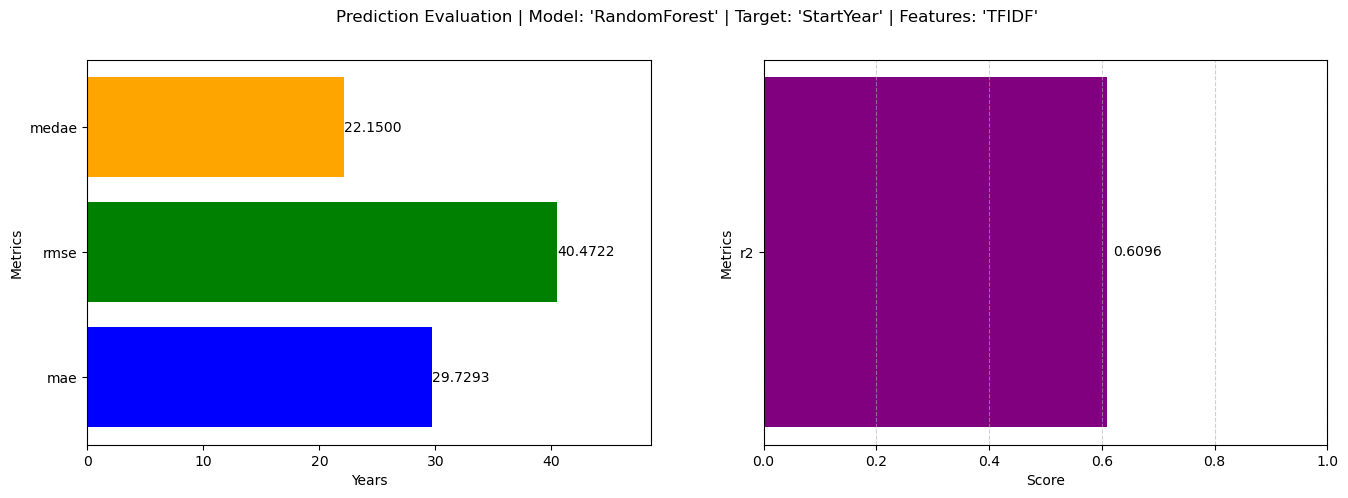

Example Sample Predictions:


,y_true,y_pred,y_std,CI_lower,CI_upper,confidence_±10,error
SAMPLE,,,,,,,
RANDOM,-400.0,-405.550,58.774548,-520.745997,-290.354003,0.135101,5.550
BEST,-482.0,-481.860,3.668842,-489.050798,-474.669202,0.993583,0.140
WORST,-350.0,-485.325,65.598833,-613.896350,-356.753650,0.121161,135.325


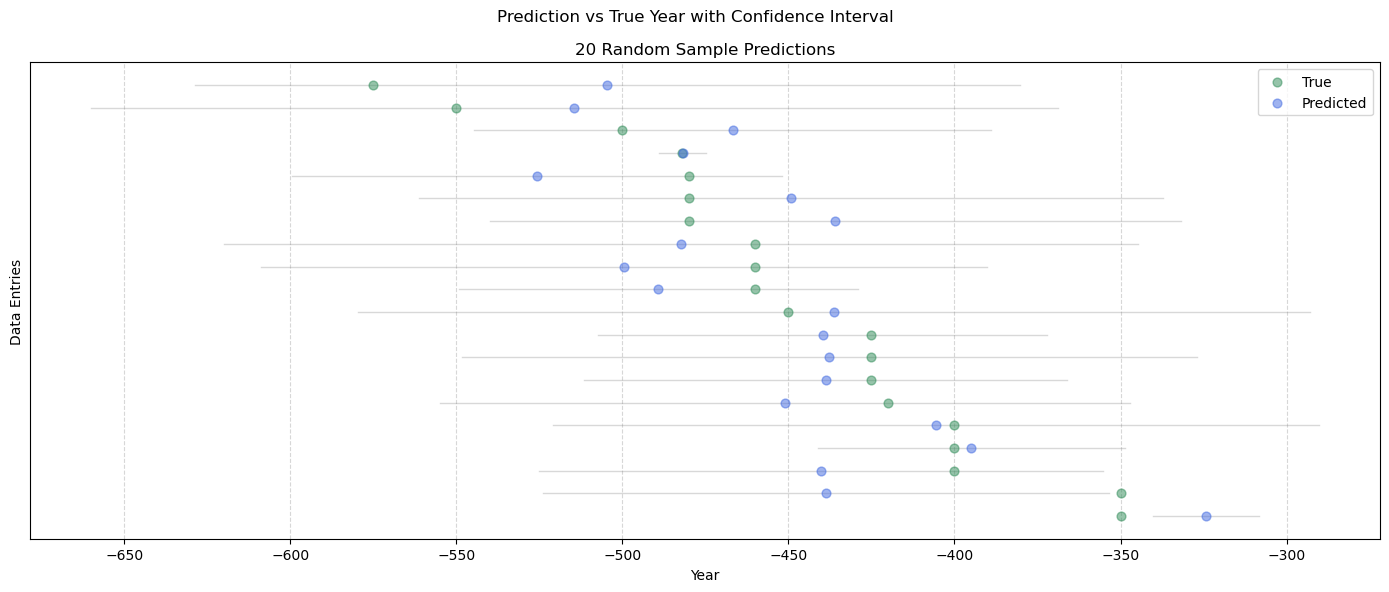

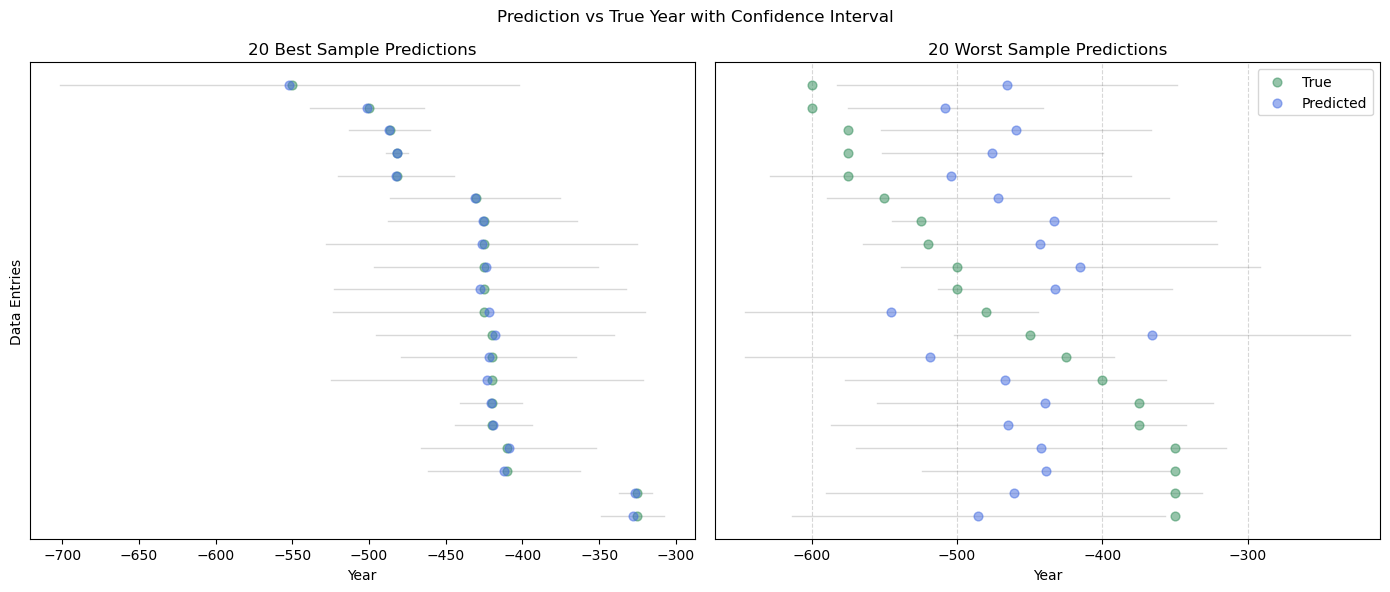

In [105]:
model_class = RandomForestRegressor
model_name = "RandomForest"
features = "tfidf"
target = "StartYear"

# model = model_class(**best_params[model_name][(features, target)])
model = initialize_model(model_class, best_params[model_name][(features, target)])
model.fit(X["train"][features], y["train"][target])
results = predict_with_std_2(model, X["test"][features], y["test"][target])

scores = evaluate(results["y_true"], results["y_pred"], metrics_r)
plot_prediction_scores(scores, model_name, target, features)

results_rand, results_best, results_worst = get_result_subsets(results, samples=20)

plot_true_vs_pred2([results_rand], ["Random"])
plot_true_vs_pred2([results_best, results_worst], ["Best", "Worst"])

In [11]:
model_class = RandomForestRegressor
model_name = "RandomForest"
features = "tfidf"
target = "StartYear"

model = model_class(**best_params[model_name][(features, target)])
model.fit(X["train"][features], y["train"][target])
y_pred, y_std = predict_with_std(model, X["test"][features])

C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.cond

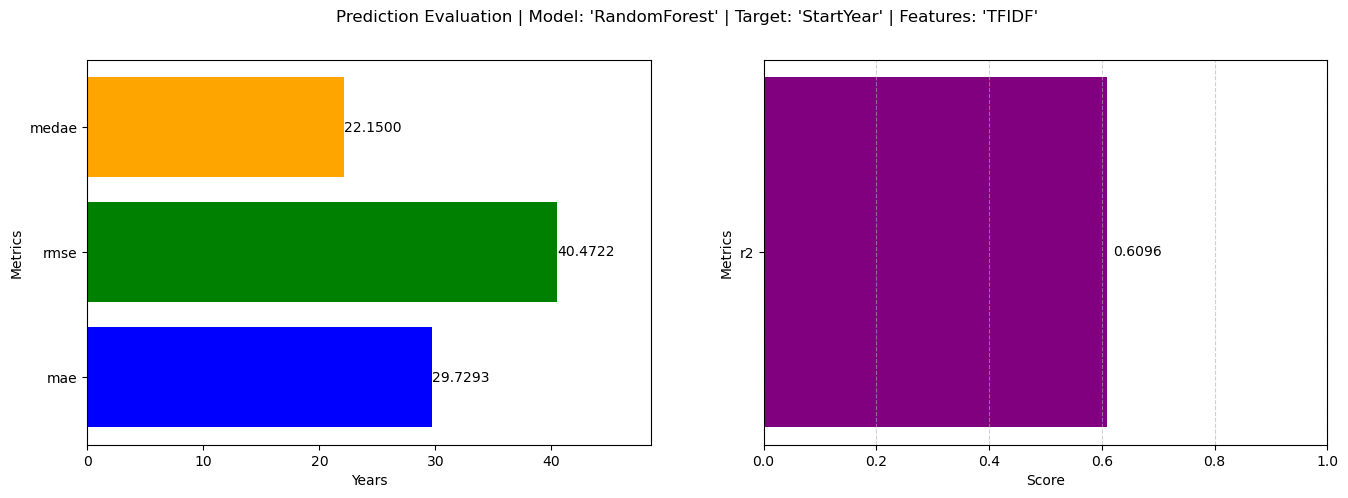

In [12]:
scores = evaluate(y["test"][target], y_pred, metrics_r)
plot_prediction_scores(scores, model_name, target, features)

In [72]:
results = get_result_table(y["test"][target], y_pred, y_std)
results_rand, results_best, results_worst = get_result_subsets(results, 20)

Example Sample Predictions:


,y_true,y_pred,y_std,error,CI_lower,CI_upper,confidence_±10
SAMPLE,,,,,,,
RANDOM,-400.0,-405.550,58.774548,5.550,-520.745997,-290.354003,0.135101
BEST,-482.0,-481.860,3.668842,0.140,-489.050798,-474.669202,0.993583
WORST,-350.0,-485.325,65.598833,135.325,-613.896350,-356.753650,0.121161


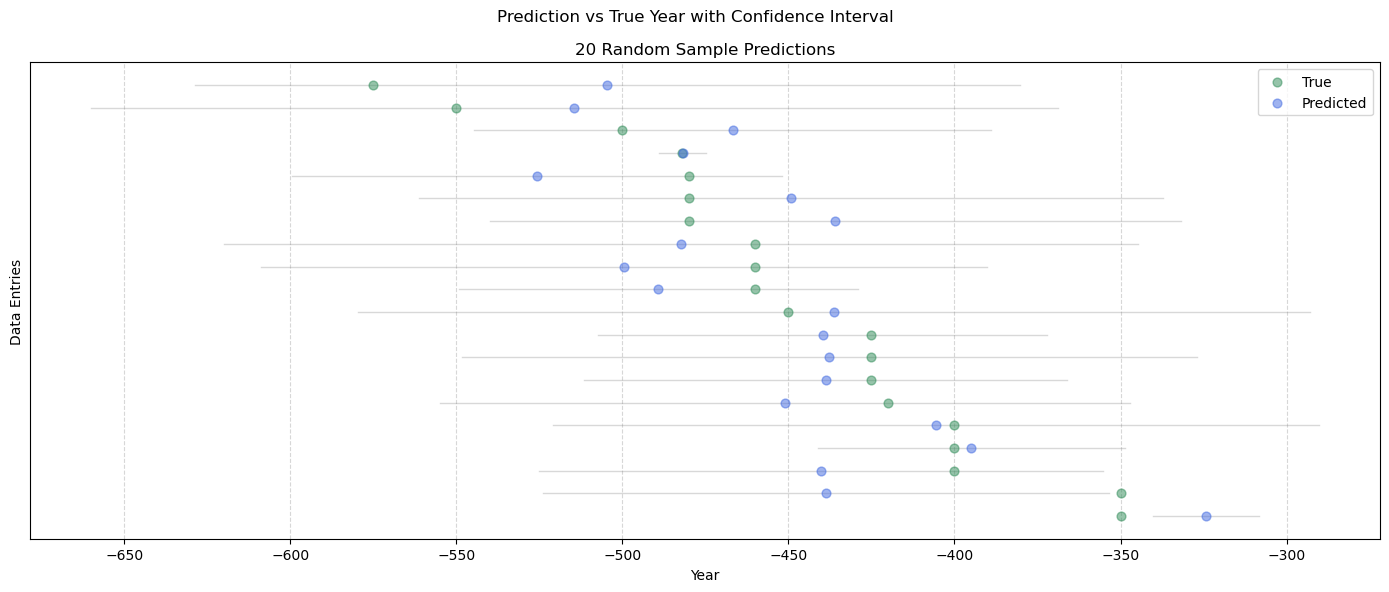

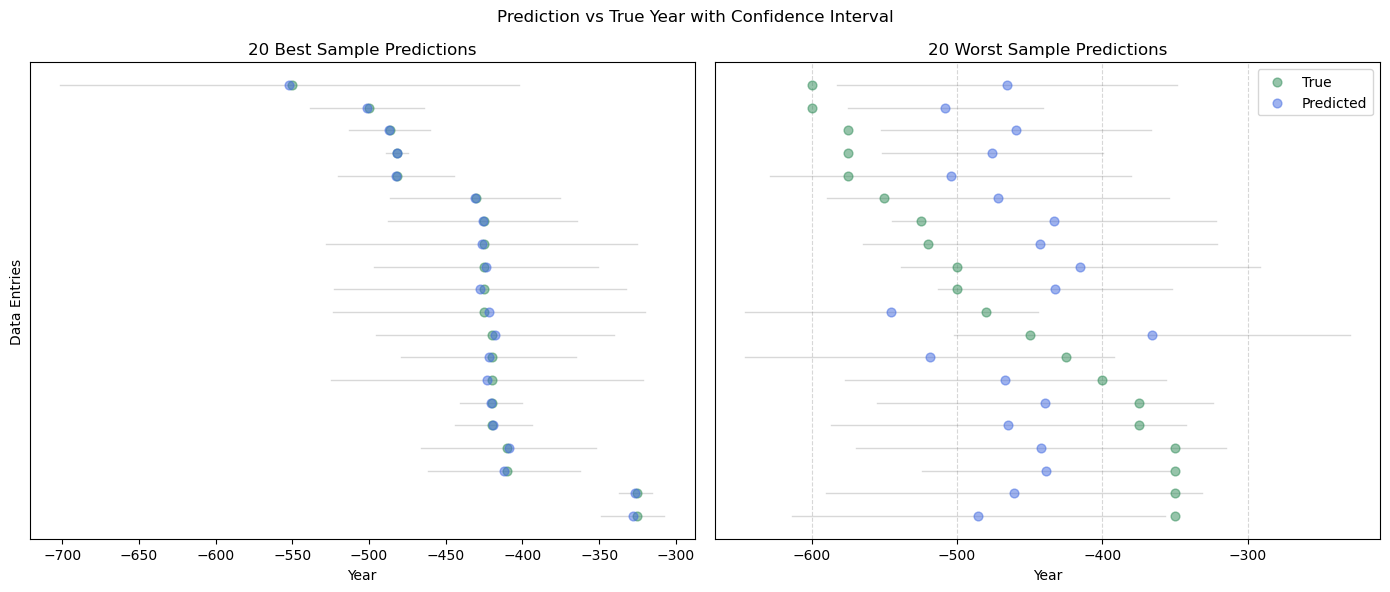

In [93]:
plot_true_vs_pred2([results_rand], ["Random"])
plot_true_vs_pred2([results_best, results_worst], ["Best", "Worst"])

## Image --> StartYear

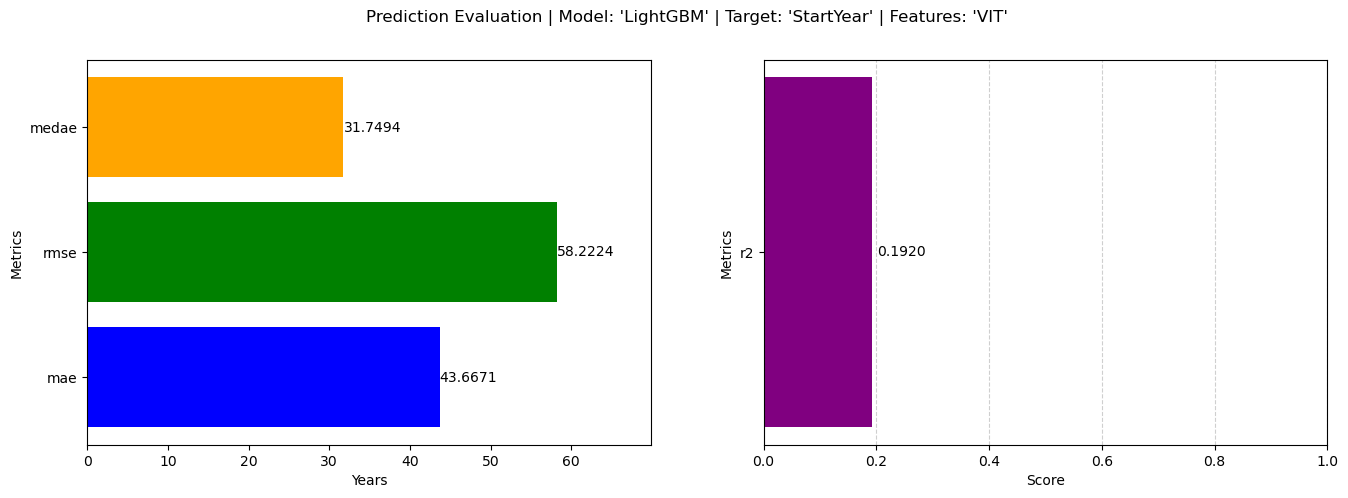

Example Sample Predictions:


,y_true,y_pred,CI_lower,CI_upper,error
SAMPLE,,,,,
RANDOM,-400.0,-400.234529,-519.619147,-323.1775,0.234529
BEST,-430.0,-430.000531,-575.000706,-325.0000,0.000531
WORST,-320.0,-464.785780,-544.530964,-325.0000,144.785780


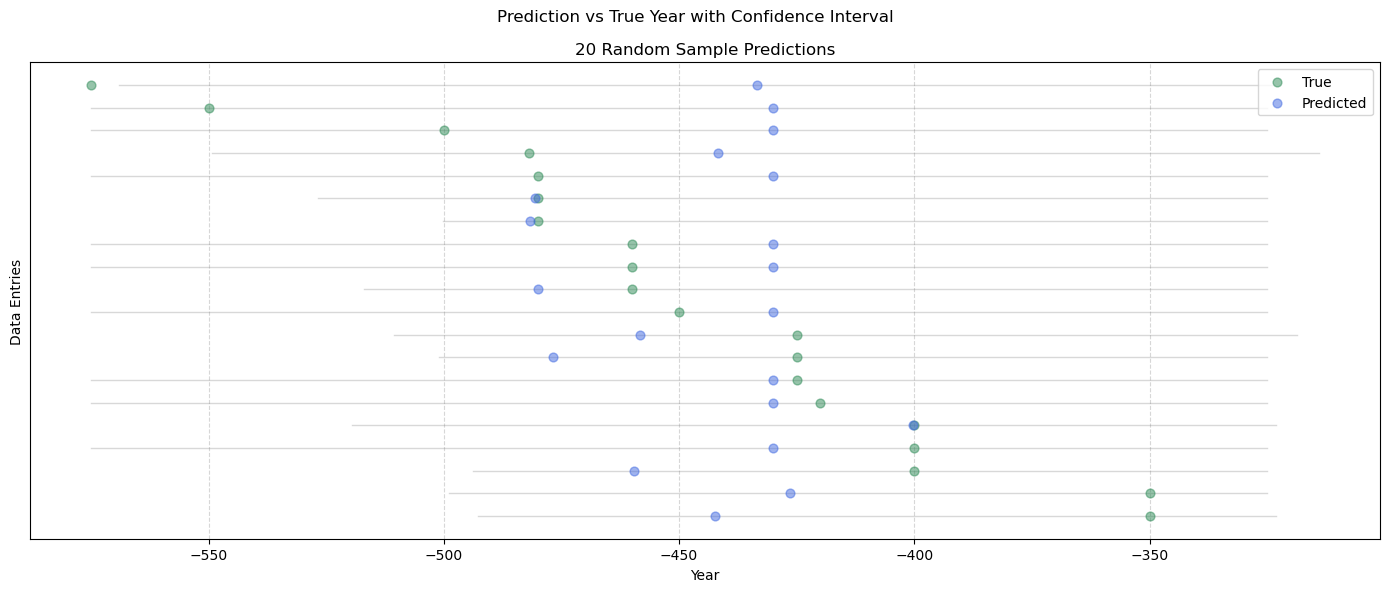

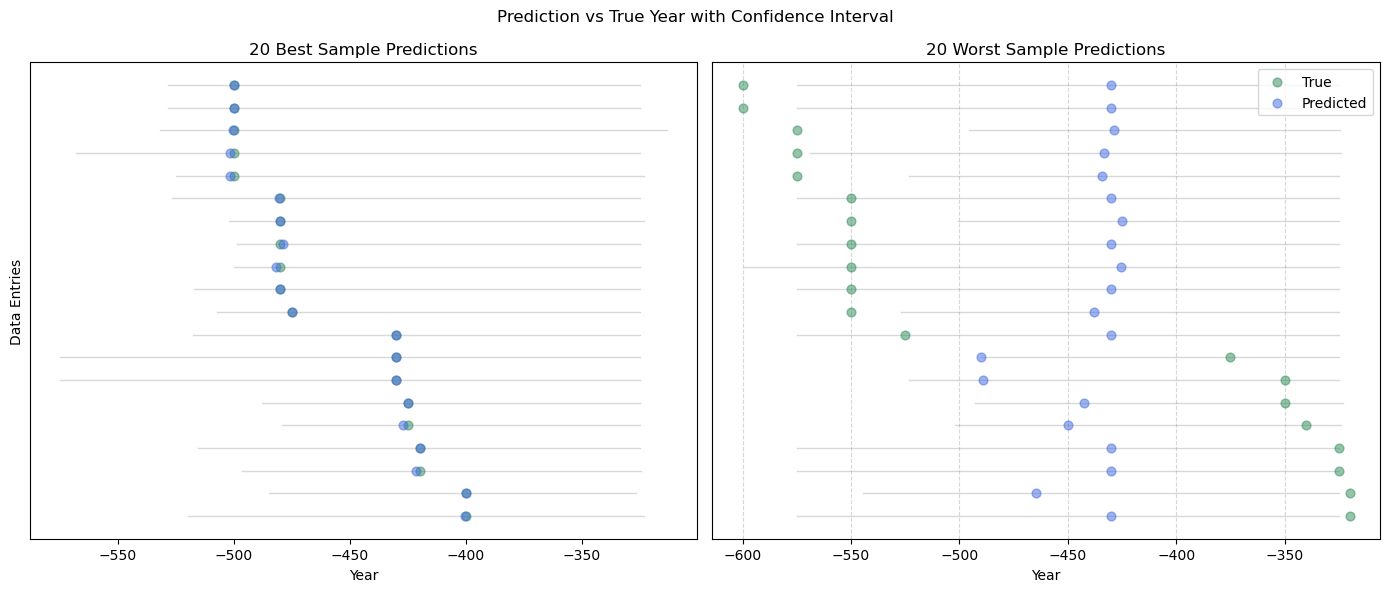

In [106]:
model_class = LGBMRegressor
model_name = "LightGBM"
features = "vit"
target = "StartYear"

# model = model_class(**best_params[model_name][(features, target)])
models = initialize_model(model_class, best_params[model_name][(features, target)])
models = fit_multimodel(models, X["train"][features], y["train"][target])
results = predict_multimodel(models, X["test"][features], y["test"][target])

scores = evaluate(results["y_true"], results["y_pred"], metrics_r)
plot_prediction_scores(scores, model_name, target, features)

results_rand, results_best, results_worst = get_result_subsets(results, samples=20)

plot_true_vs_pred2([results_rand], ["Random"])
plot_true_vs_pred2([results_best, results_worst], ["Best", "Worst"])

In [74]:
features = "vit"
target = "StartYear"

models = {name: LGBMRegressor(**best_params["LightGBM"][(features, target)], objective="quantile", alpha=alpha) for name, alpha in {"y_pred": 0.5, "CI_lower": 0.025, "CI_upper": 0.975}.items()}
results = {"y_true": y["test"][target]}
for name, model in models.items():
    model.fit(X["train"][features], y["train"][target])
    results[name] = model.predict(X["test"][features])
results = pd.DataFrame(results)
results

,y_true,y_pred,CI_lower,CI_upper
0,-525.0,-521.731396,-575.028558,-325.000000
1,-425.0,-430.000531,-575.000740,-325.000000
2,-375.0,-459.982865,-498.730292,-325.000000
3,-600.0,-554.031177,-625.023137,-325.000000
4,-500.0,-430.000531,-575.000740,-325.000000
...,...,...,...,...
186,-500.0,-452.546128,-507.062832,-323.940555
187,-500.0,-464.521244,-481.428345,-322.852213
188,-500.0,-430.000531,-575.000740,-325.000000
189,-375.0,-430.000531,-575.000740,-325.000000


In [75]:
scores = evaluate(results["y_true"], results["y_pred"], metrics_r)
scores

{'mae': 43.66708114197519,
 'rmse': 58.222390508760384,
 'r2': 0.19204092308743037,
 'medae': 31.74942033912248,
 'maxerror:': 169.99946877202228}

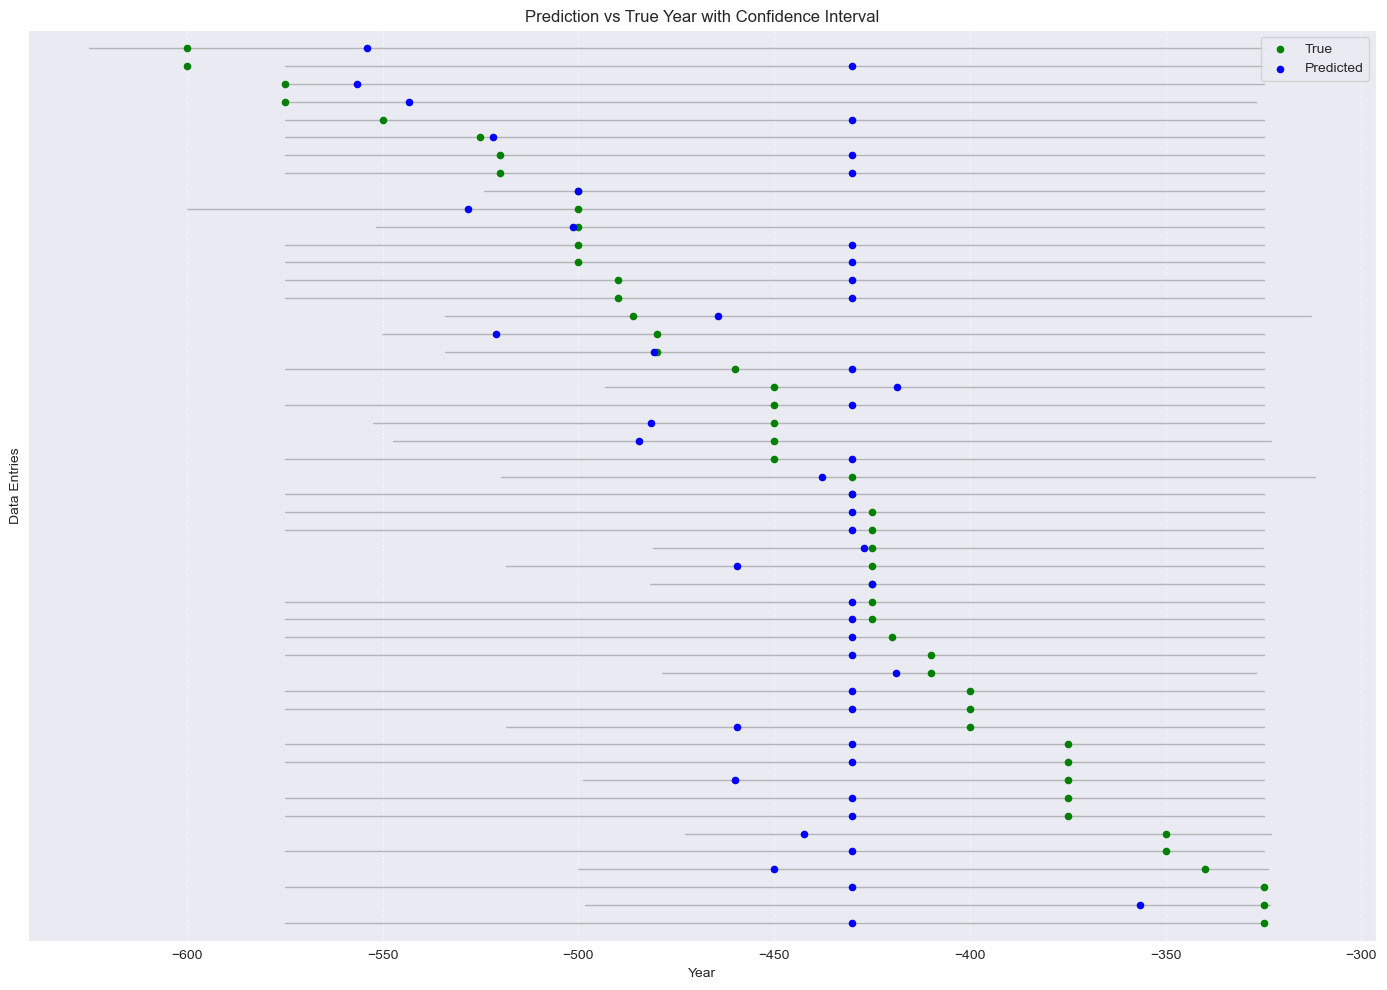

In [76]:
plot_true_vs_pred(results, 50)

## Text+Image Combo --> StartYear

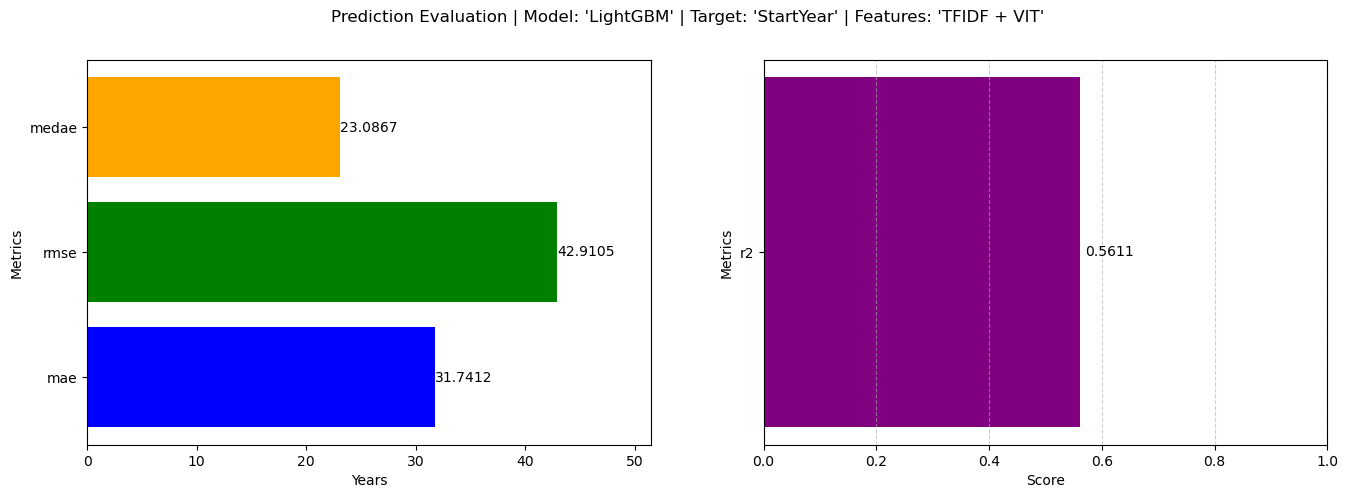

Example Sample Predictions:


,y_true,y_pred,CI_lower,CI_upper,error
SAMPLE,,,,,
RANDOM,-400.0,-428.550967,-529.640378,-332.984539,28.550967
BEST,-482.0,-482.000117,-514.522120,-365.541264,0.000117
WORST,-315.0,-397.957853,-501.906441,-335.610871,82.957853


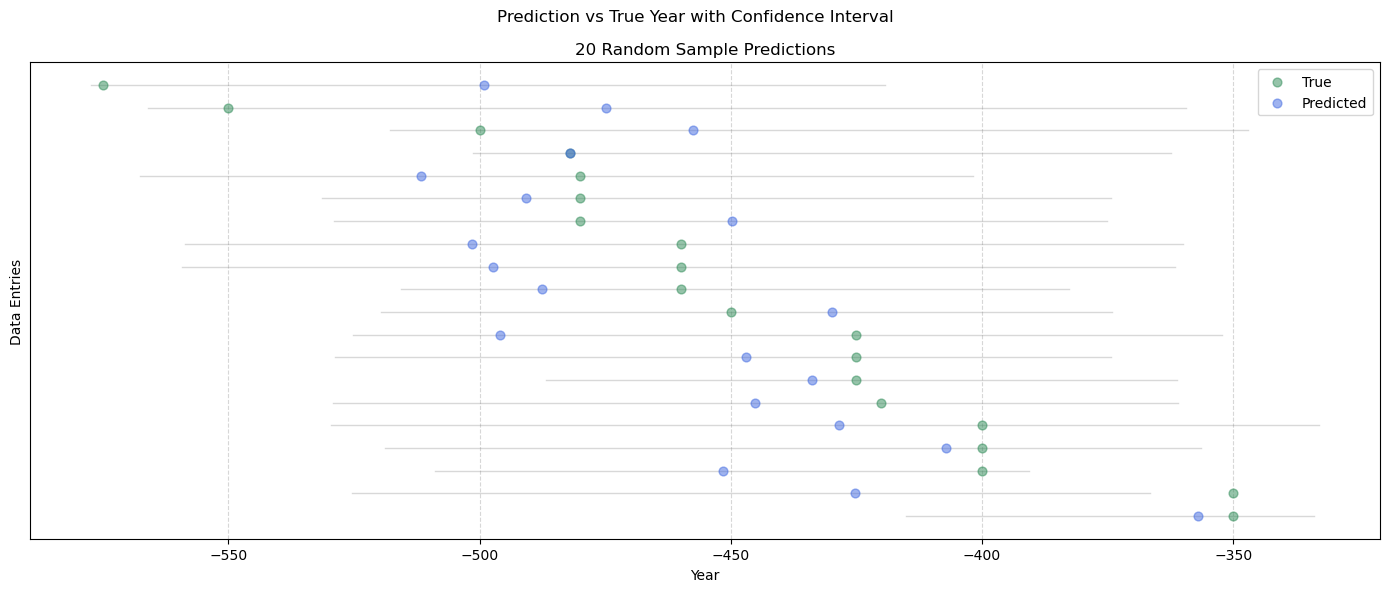

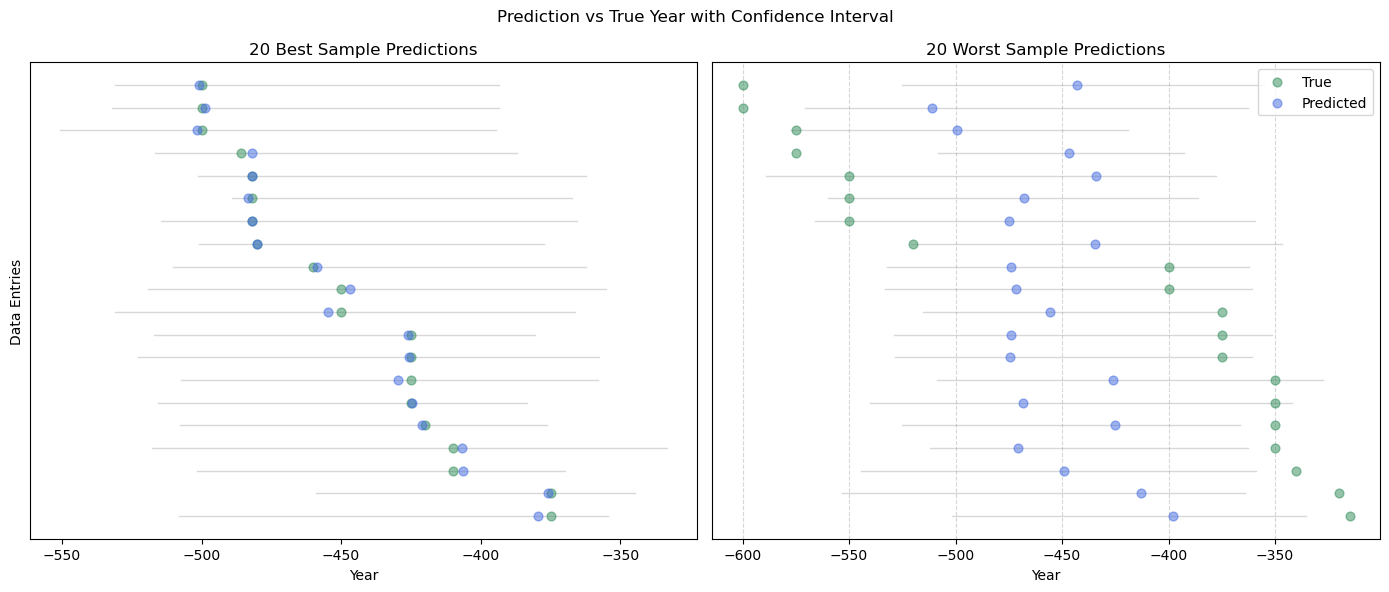

In [112]:
model_class = LGBMRegressor
model_name = "LightGBM"
features = "tfidf + vit"
target = "StartYear"

# model = model_class(**best_params[model_name][(features, target)])
models = initialize_model(model_class, best_params[model_name][(features, target)])
models = fit_multimodel(models, X["train"][features], y["train"][target])
results = predict_multimodel(models, X["test"][features], y["test"][target])

scores = evaluate(results["y_true"], results["y_pred"], metrics_r)
plot_prediction_scores(scores, model_name, target, features)

results_rand, results_best, results_worst = get_result_subsets(results, samples=20)

plot_true_vs_pred2([results_rand], ["Random"])
plot_true_vs_pred2([results_best, results_worst], ["Best", "Worst"])

In [81]:
f_txt = "tfidf"
f_img = "vit"
target = "StartYear"

models = {name: LGBMRegressor(**best_params["LightGBM"][(f"{f_txt} + {f_img}", target)], objective="quantile", alpha=alpha) for name, alpha in {"y_pred": 0.5, "CI_lower": 0.025, "CI_upper": 0.975}.items()}
results = {"y_true": y["test"][target]}
for name, model in models.items():
    X_train = combine_features([X["train"][f_txt], X["train"][f_img]])
    X_test = combine_features([X["test"][f_txt], X["test"][f_img]])

    model.fit(X_train, y["train"][target])
    results[name] = model.predict(X_test)

results = pd.DataFrame(results)
results

,y_true,y_pred,CI_lower,CI_upper
0,-525.0,-494.666903,-528.967795,-396.696979
1,-425.0,-429.609255,-513.426570,-358.594343
2,-375.0,-455.476798,-498.498668,-378.306288
3,-600.0,-562.555462,-593.716029,-357.498297
4,-500.0,-489.687637,-517.307929,-350.146097
...,...,...,...,...
186,-500.0,-487.642540,-515.076972,-359.897767
187,-500.0,-454.368990,-513.558917,-378.474027
188,-500.0,-461.131444,-545.263618,-360.526911
189,-375.0,-474.276195,-529.329174,-360.434038


In [82]:
scores = evaluate(results["y_true"], results["y_pred"], metrics_r)
scores

{'mae': 31.741237154225953,
 'rmse': 42.91048980632808,
 'r2': 0.5611296485759226,
 'medae': 23.086699859917758,
 'maxerror:': 156.7891325270084}

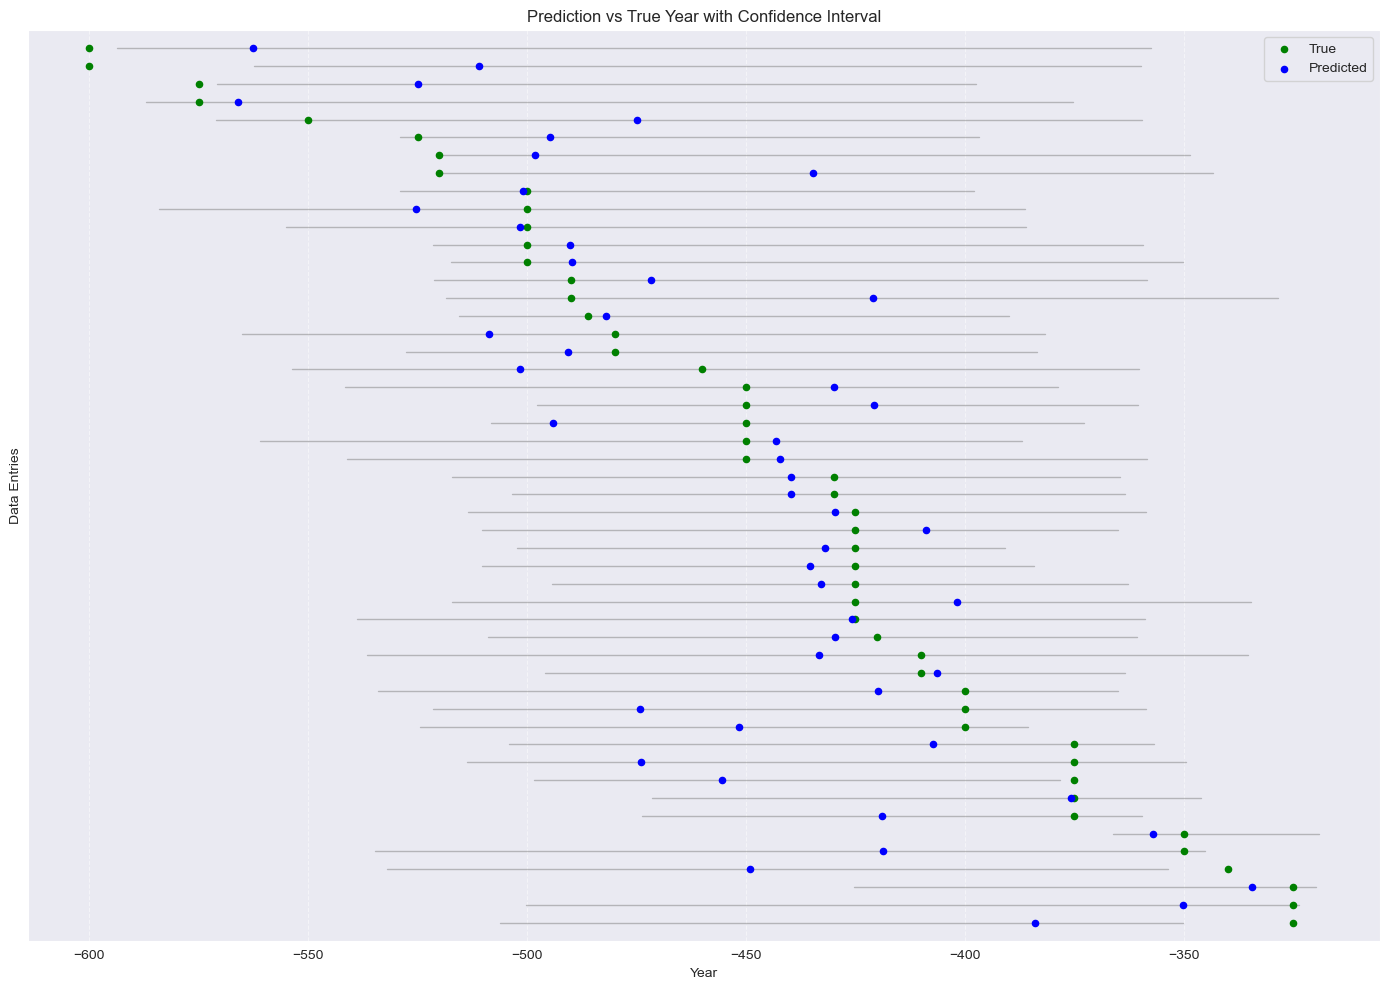

In [83]:
plot_true_vs_pred(results, 50)

## Text --> YearRange

C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.cond

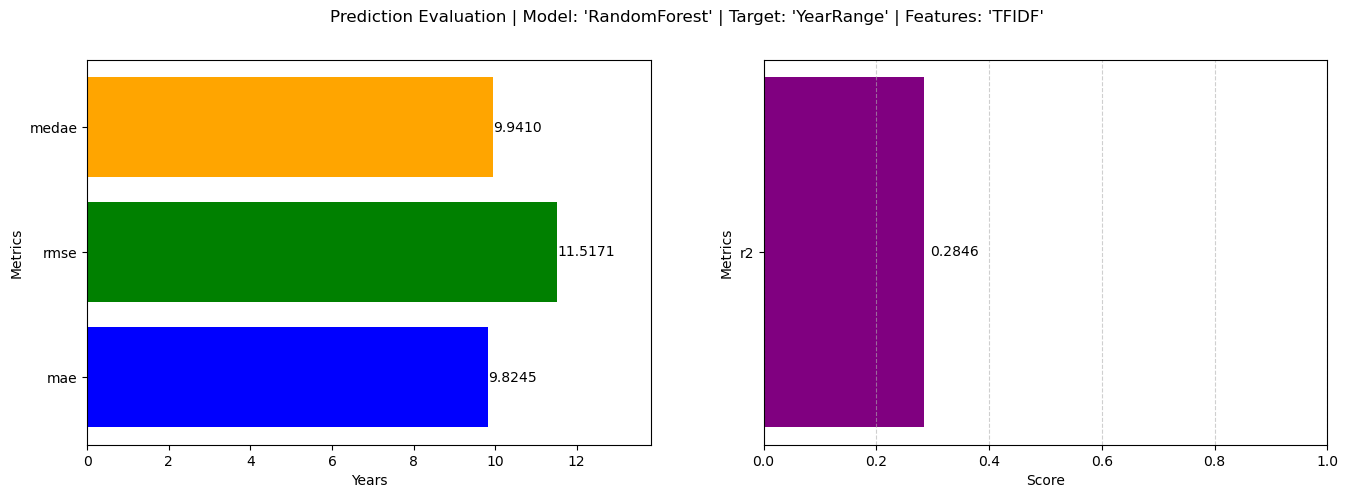

Example Sample Predictions:


,y_true,y_pred,y_std,CI_lower,CI_upper,confidence_±10,error
SAMPLE,,,,,,,
RANDOM,50.0,22.924746,12.644531,-1.858078,47.707571,0.570972,27.075254
BEST,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
WORST,50.0,18.468793,9.729761,-0.601189,37.538774,0.695944,31.531207


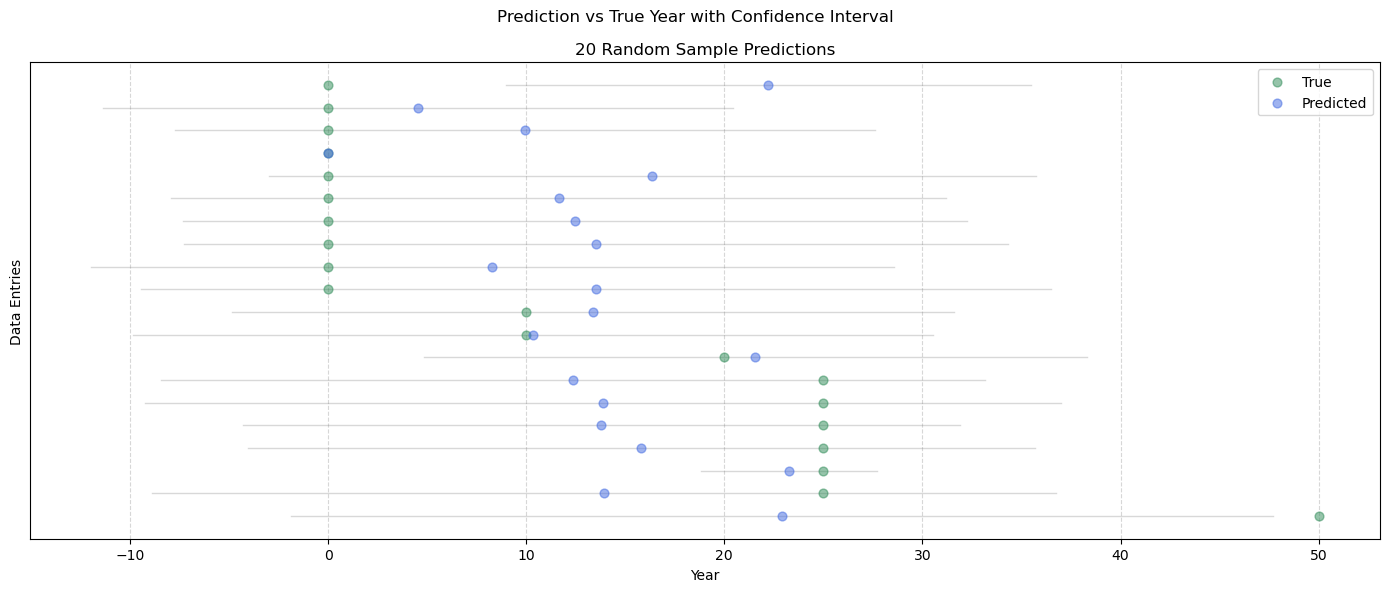

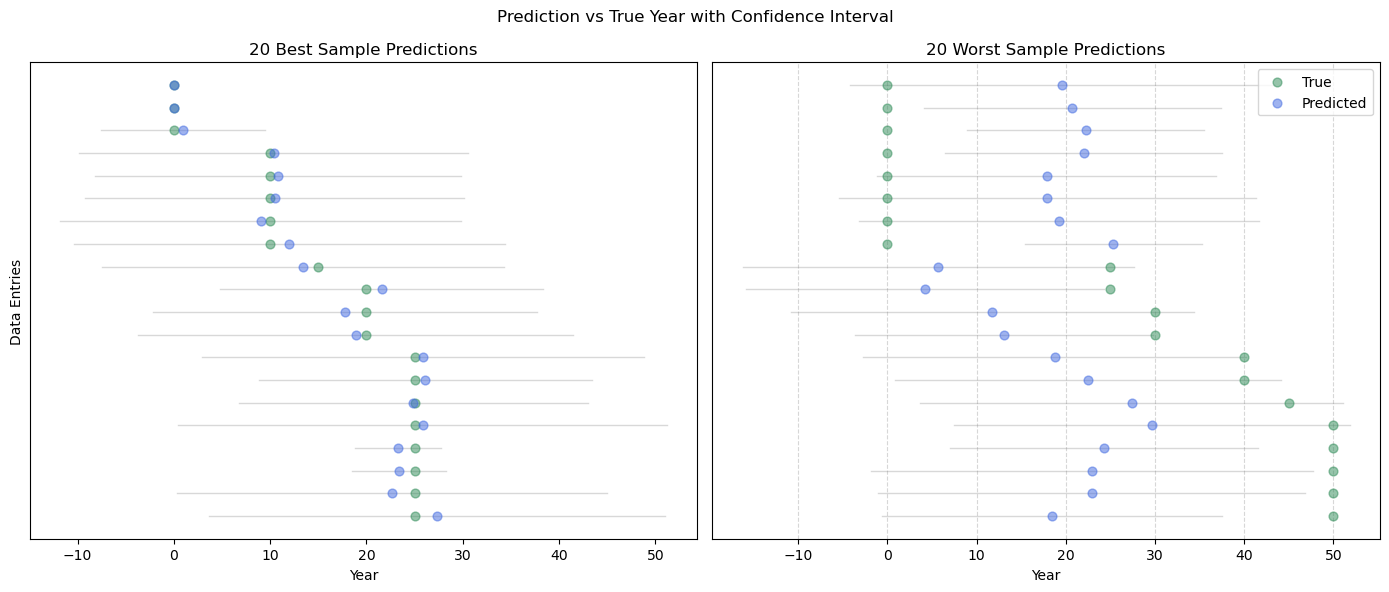

In [113]:
model_class = RandomForestRegressor
model_name = "RandomForest"
features = "tfidf"
target = "YearRange"

model = initialize_model(model_class, best_params[model_name][(features, target)])
model.fit(X["train"][features], y["train"][target])
results = predict_with_std_2(model, X["test"][features], y["test"][target])

scores = evaluate(results["y_true"], results["y_pred"], metrics_r)
plot_prediction_scores(scores, model_name, target, features)

results_rand, results_best, results_worst = get_result_subsets(results, samples=20)

plot_true_vs_pred2([results_rand], ["Random"])
plot_true_vs_pred2([results_best, results_worst], ["Best", "Worst"])

In [84]:
model_class = RandomForestRegressor
model_name = "RandomForest"
features = "tfidf"
target = "YearRange"

model = model_class(**best_params[model_name][(features, target)])
model.fit(X["train"][features], y["train"][target])
y_pred, y_std = predict_with_std(model, X["test"][features])

C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.cond

In [85]:
scores = evaluate(y["test"][target], y_pred, metrics_r)
scores

{'mae': 9.824539566187344,
 'rmse': 11.51714508670036,
 'r2': 0.28461265347494225,
 'medae': 9.941008912938758,
 'maxerror:': 31.531207362910628}

In [86]:
results = get_result_table(y["test"][target], y_pred, y_std)
results

,y_true,y_pred,y_std,CI_lower,CI_upper,confidence_±10
0,0.0,15.178384,11.101693,-6.580535,36.937303,0.632286
1,25.0,11.557712,11.397305,-10.780595,33.896019,0.619731
2,25.0,23.368966,2.480340,18.507588,28.230344,0.999945
3,25.0,17.341210,14.506276,-11.090568,45.772987,0.509401
4,25.0,19.750000,10.182706,-0.207737,39.707737,0.673928
...,...,...,...,...,...,...
186,25.0,21.882851,7.578994,7.028296,36.737407,0.812977
187,20.0,14.191575,10.356184,-6.106174,34.489323,0.665759
188,20.0,16.851790,12.630662,-7.903854,41.607433,0.571478
189,50.0,24.278657,8.796849,7.037149,41.520165,0.744366


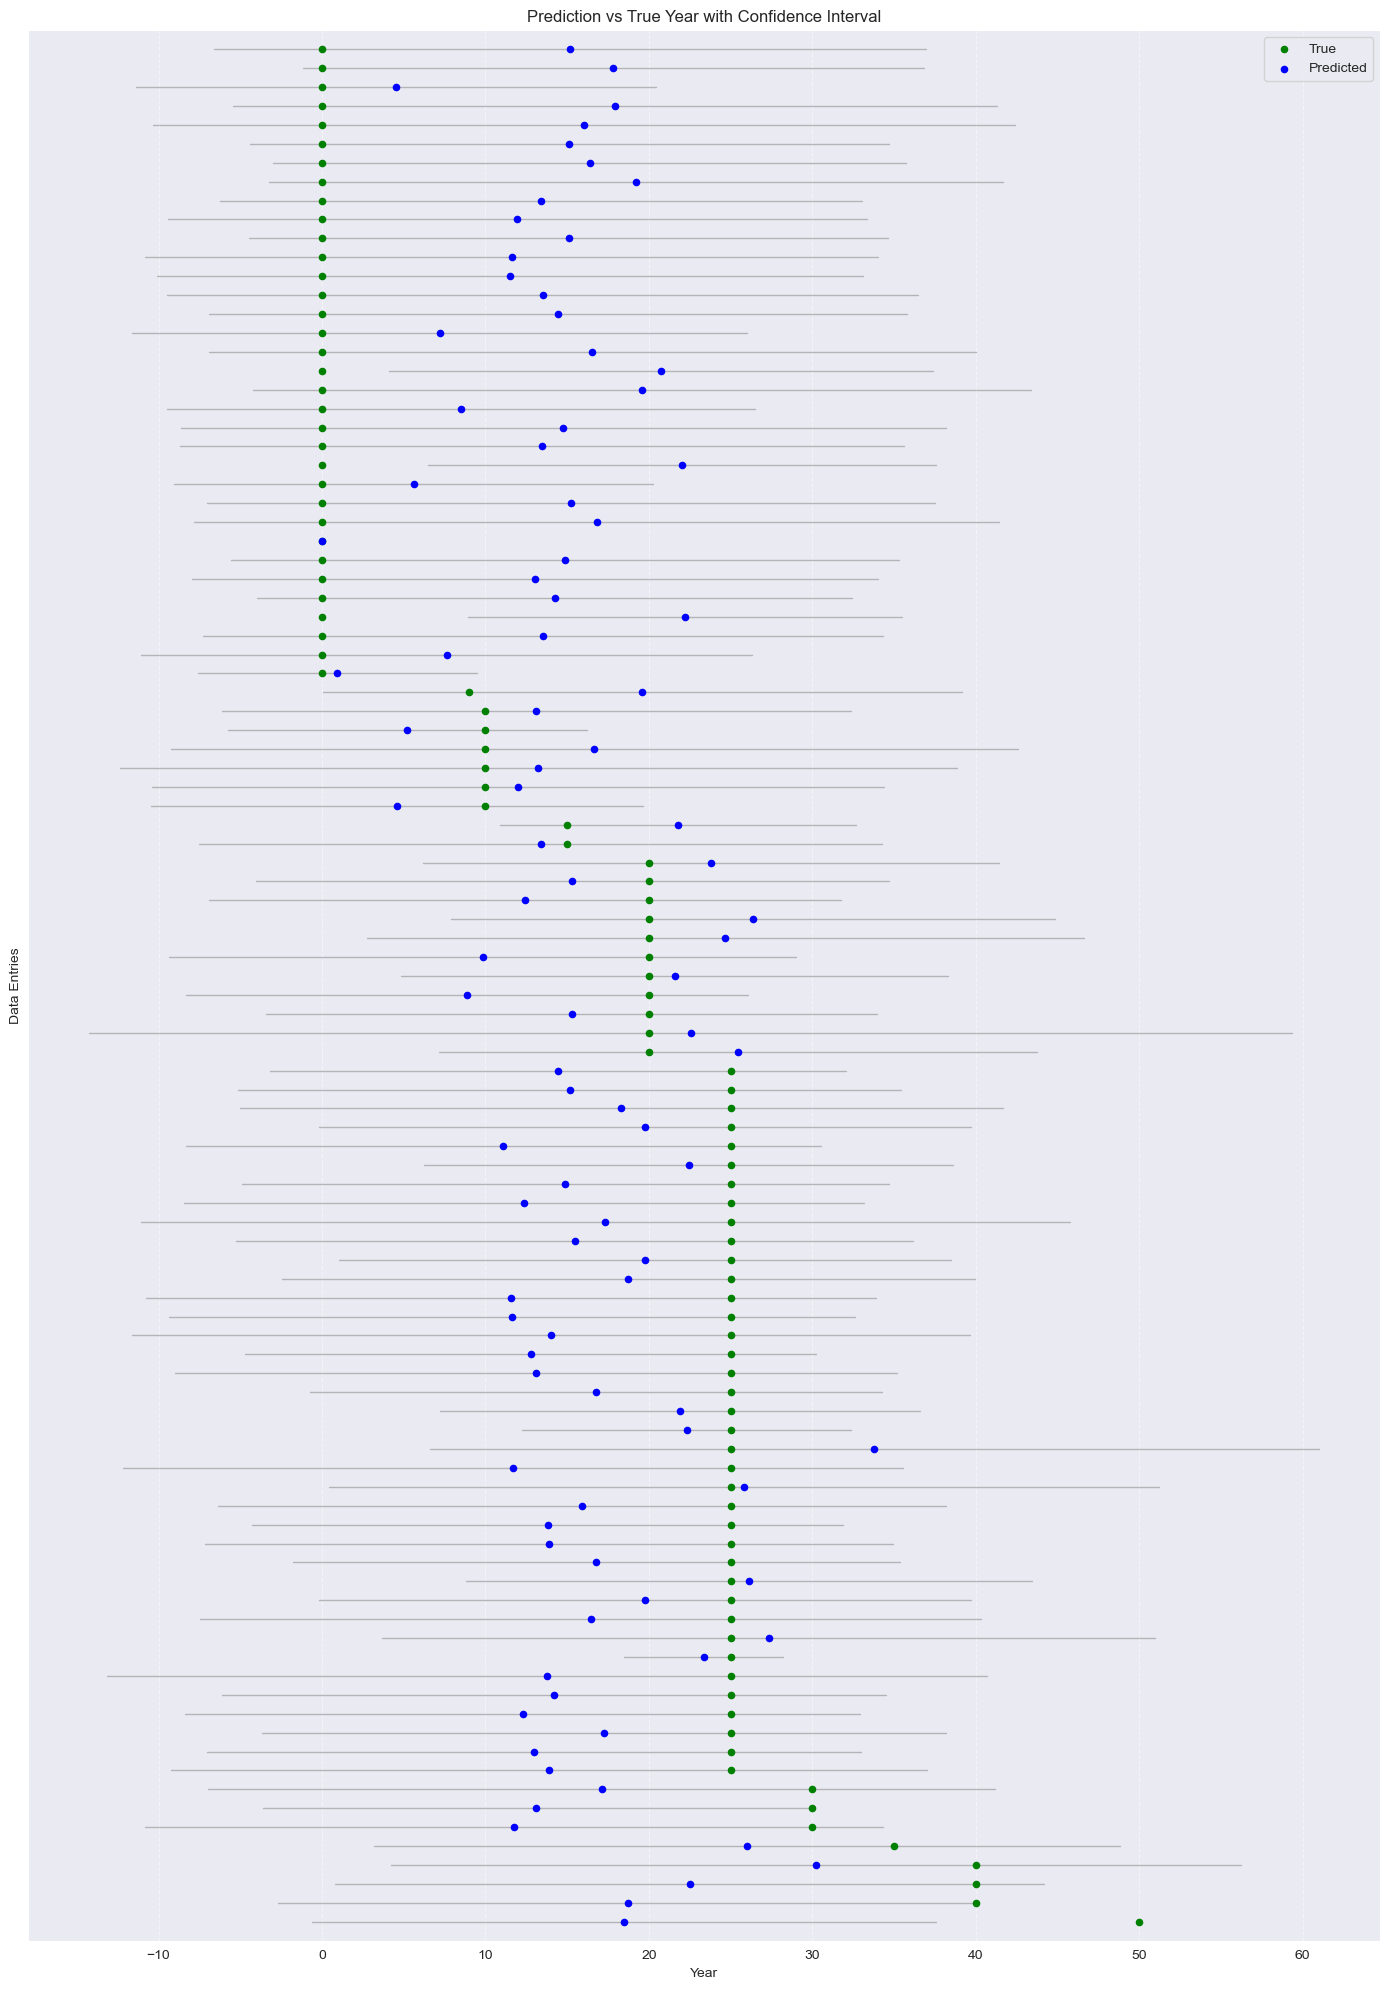

In [88]:
plot_true_vs_pred(results, 100)

## Image --> YearRange

C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X

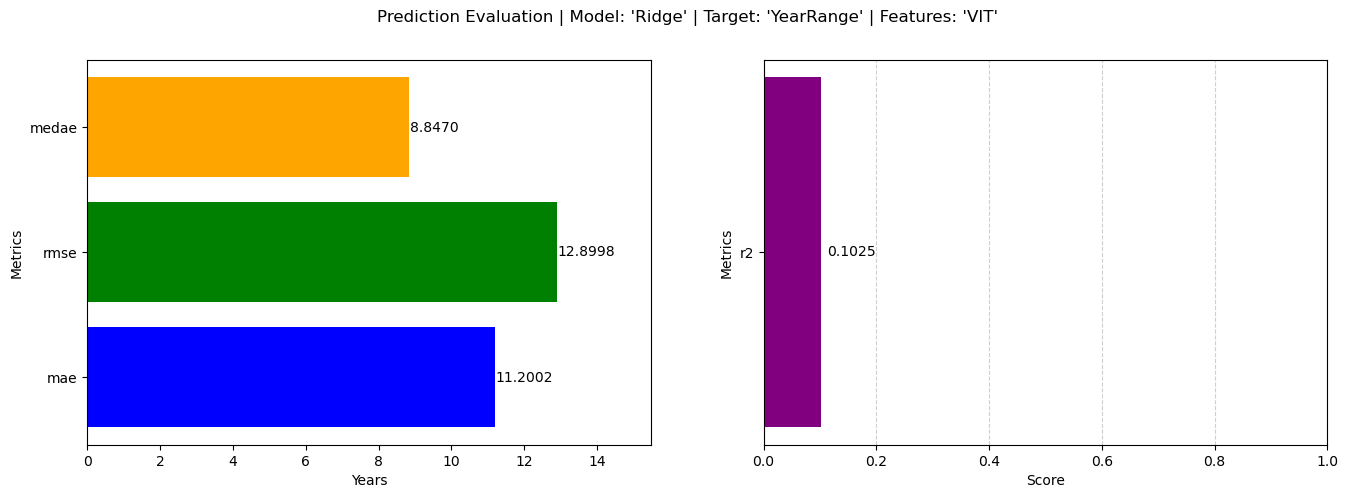

Example Sample Predictions:


,y_true,y_pred,y_std,CI_lower,CI_upper,confidence_±10,error
SAMPLE,,,,,,,
RANDOM,50.0,22.195320,3.479022,15.376563,29.014078,0.995952,27.804680
BEST,25.0,25.089905,2.005410,21.159373,29.020437,0.999999,0.089905
WORST,50.0,16.476604,0.474573,15.546459,17.406749,1.000000,33.523396


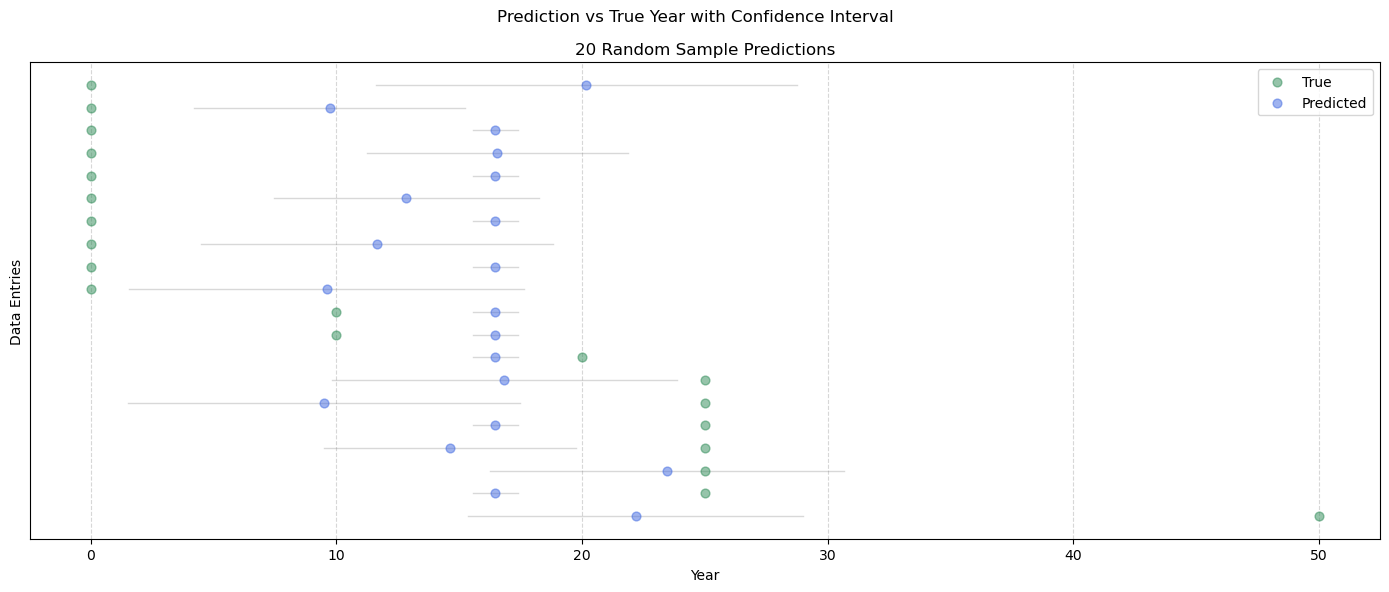

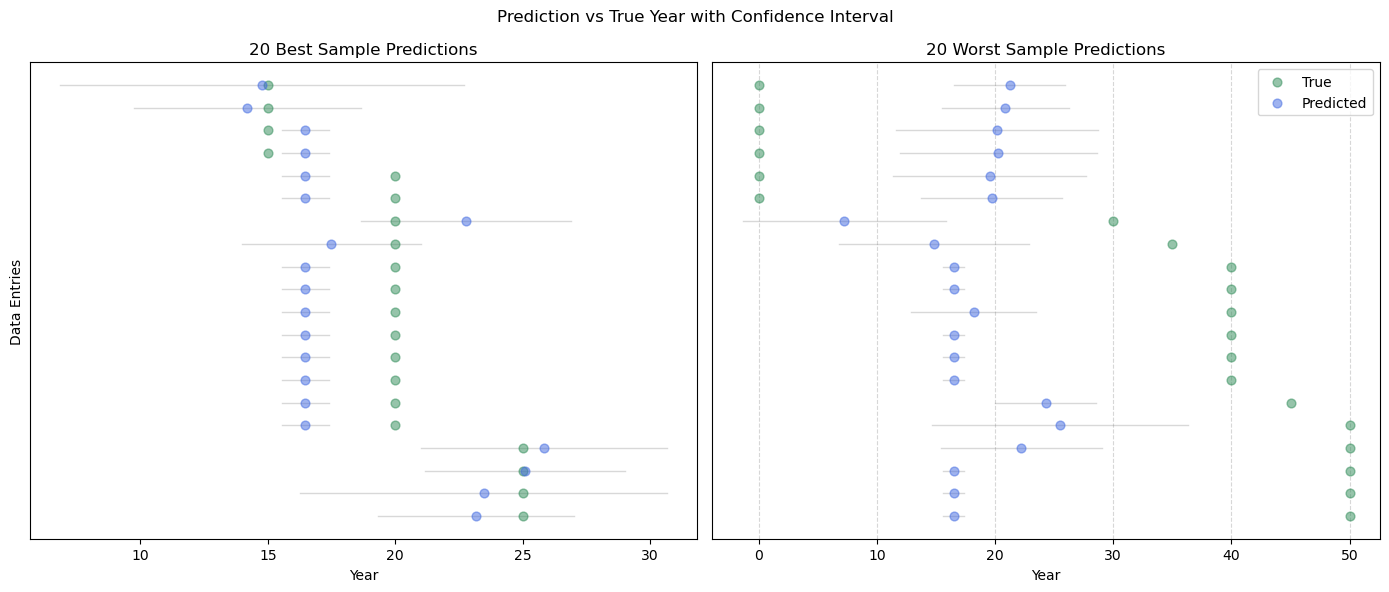

In [114]:
model_class = Ridge
model_name = "Ridge"
features = "vit"
target = "YearRange"

model = initialize_model(model_class, best_params[model_name][(features, target)])
model.fit(X["train"][features], y["train"][target])
results = predict_with_std_2(model, X["test"][features], y["test"][target])

scores = evaluate(results["y_true"], results["y_pred"], metrics_r)
plot_prediction_scores(scores, model_name, target, features)

results_rand, results_best, results_worst = get_result_subsets(results, samples=20)

plot_true_vs_pred2([results_rand], ["Random"])
plot_true_vs_pred2([results_best, results_worst], ["Best", "Worst"])

In [105]:
features = "vit"
target = "YearRange"

model = BaggingRegressor(estimator=Ridge(**best_params["Ridge"][(features, target)]), n_estimators=50, bootstrap=True, n_jobs=-1)
model.fit(X["train"][features], y["train"][target])
y_pred, y_std = predict_with_std(model, X["test"][features])

C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X

In [106]:
scores = evaluate(y["test"][target], y_pred, metrics_r)
scores

{'mae': 11.121109173845499,
 'rmse': 12.829299621330822,
 'r2': 0.11231787554442862,
 'medae': 8.383880085960865,
 'maxerror:': 33.38071260313935}

In [107]:
results = get_result_table(y["test"][target], y_pred, y_std)
results

,y_true,y_pred,y_std,CI_lower,CI_upper,confidence_±10
0,0.0,17.648564,2.943939,11.878549,23.418578,0.999318
1,25.0,16.619287,0.433457,15.769727,17.468848,1.000000
2,25.0,22.605823,1.827666,19.023663,26.187983,1.000000
3,25.0,20.358324,3.525996,13.447499,27.269149,0.995433
4,25.0,16.619287,0.433457,15.769727,17.468848,1.000000
...,...,...,...,...,...,...
186,25.0,11.356697,2.905914,5.661211,17.052183,0.999421
187,20.0,13.784891,3.506351,6.912569,20.657213,0.995655
188,20.0,16.619287,0.433457,15.769727,17.468848,1.000000
189,50.0,16.619287,0.433457,15.769727,17.468848,1.000000


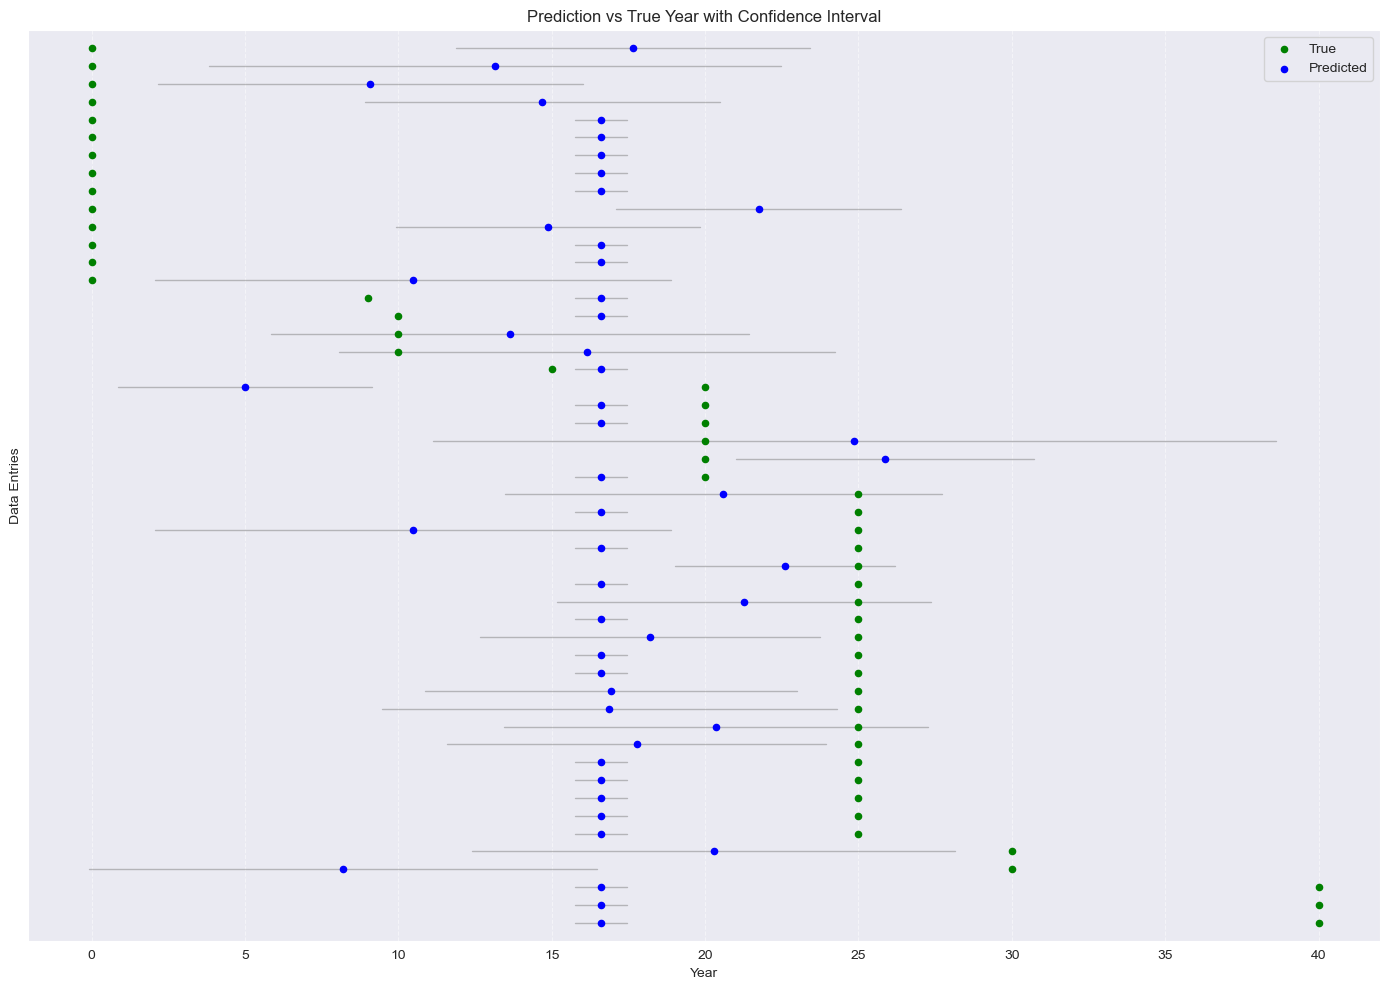

In [109]:
plot_true_vs_pred(results, 50)

## Text + Image Combo --> YearRange

C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.cond

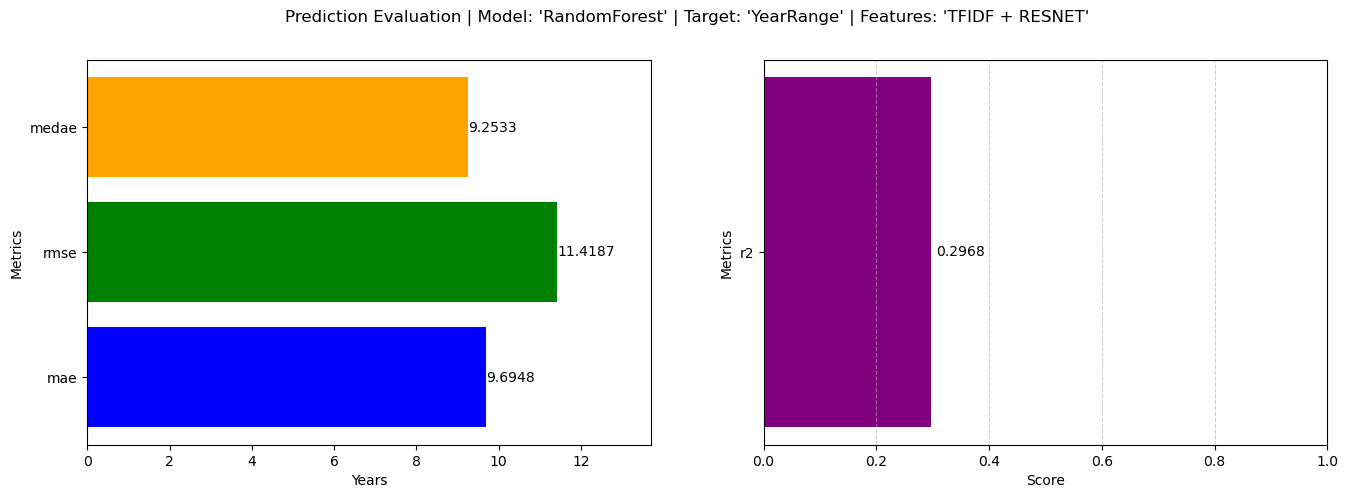

Example Sample Predictions:


,y_true,y_pred,y_std,CI_lower,CI_upper,confidence_±10,error
SAMPLE,,,,,,,
RANDOM,50.0,22.579405,15.387242,-7.579036,52.737845,0.484236,27.420595
BEST,25.0,24.881071,13.341447,-1.267684,51.029827,0.546471,0.118929
WORST,50.0,21.707738,9.237783,3.602015,39.813461,0.720974,28.292262


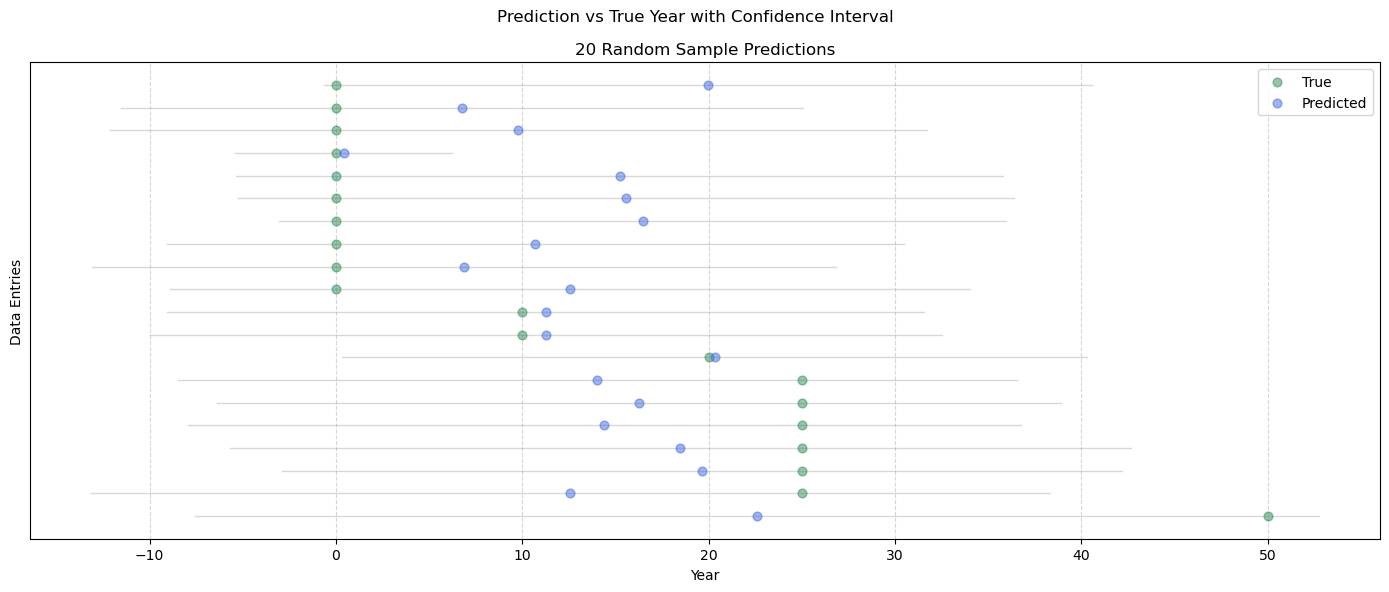

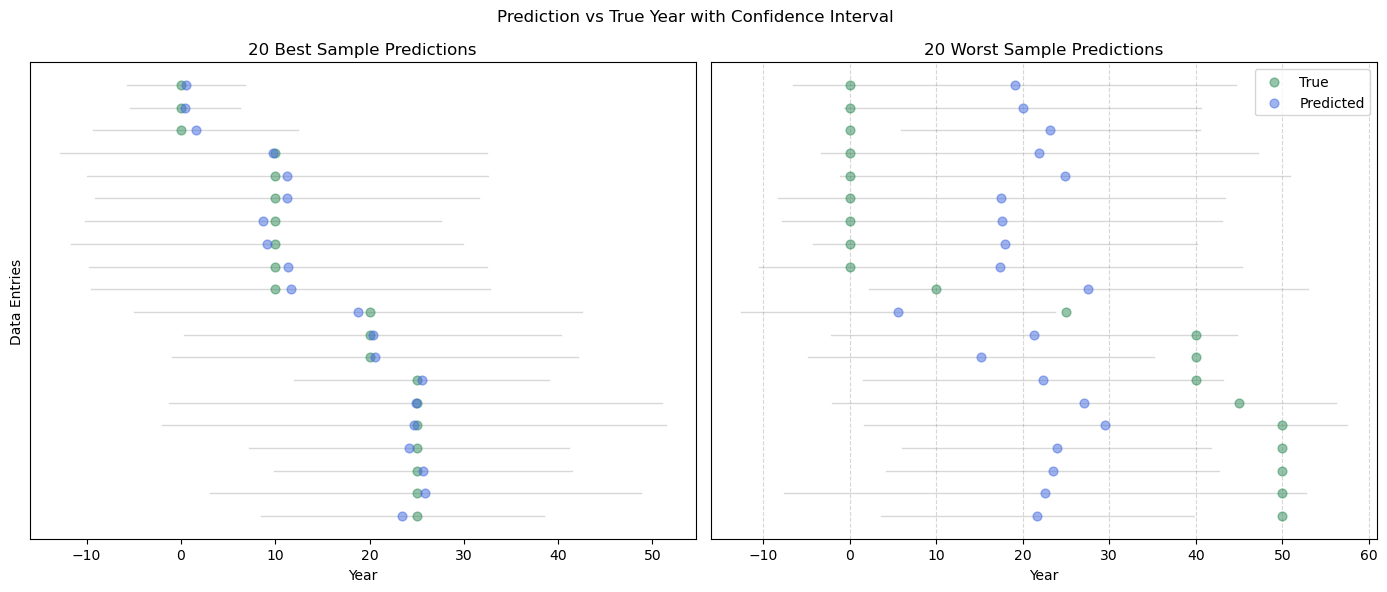

In [115]:
model_class = RandomForestRegressor
model_name = "RandomForest"
features = "tfidf + resnet"
target = "YearRange"

model = initialize_model(model_class, best_params[model_name][(features, target)])
model.fit(X["train"][features], y["train"][target])
results = predict_with_std_2(model, X["test"][features], y["test"][target])

scores = evaluate(results["y_true"], results["y_pred"], metrics_r)
plot_prediction_scores(scores, model_name, target, features)

results_rand, results_best, results_worst = get_result_subsets(results, samples=20)

plot_true_vs_pred2([results_rand], ["Random"])
plot_true_vs_pred2([results_best, results_worst], ["Best", "Worst"])

In [110]:
model_class = RandomForestRegressor
model_name = "RandomForest"
f_txt = "tfidf"
f_img = "resnet"
target = "YearRange"

model = model_class(**best_params[model_name][(f"{f_txt} + {f_img}", target)])

X_train = combine_features([X["train"][f_txt], X["train"][f_img]])
X_test = combine_features([X["test"][f_txt], X["test"][f_img]])

model.fit(X_train, y["train"][target])
y_pred, y_std = predict_with_std(model, X_test)

C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.cond

In [111]:
scores = evaluate(y["test"][target], y_pred, metrics_r)
scores

{'mae': 9.69481814593202,
 'rmse': 11.418703879219295,
 'r2': 0.29678973828312893,
 'medae': 9.253333333333334,
 'maxerror:': 28.2922619047619}

In [112]:
results = get_result_table(y["test"][target], y_pred, y_std)
results

,y_true,y_pred,y_std,CI_lower,CI_upper,confidence_±10
0,0.0,16.082500,13.002860,-9.402638,41.567638,0.558143
1,25.0,13.937024,13.107028,-11.752279,39.626327,0.554506
2,25.0,21.990000,5.732065,10.755359,33.224641,0.918941
3,25.0,28.033333,17.497770,-6.261665,62.328332,0.432340
4,25.0,16.400000,10.514131,-4.207318,37.007318,0.658447
...,...,...,...,...,...,...
186,25.0,19.939762,10.395205,-0.434465,40.313989,0.663941
187,20.0,9.269167,9.900799,-10.136042,28.674375,0.687514
188,20.0,15.763393,12.938568,-9.595735,41.122521,0.560408
189,50.0,23.458452,9.810723,4.229789,42.687115,0.691936


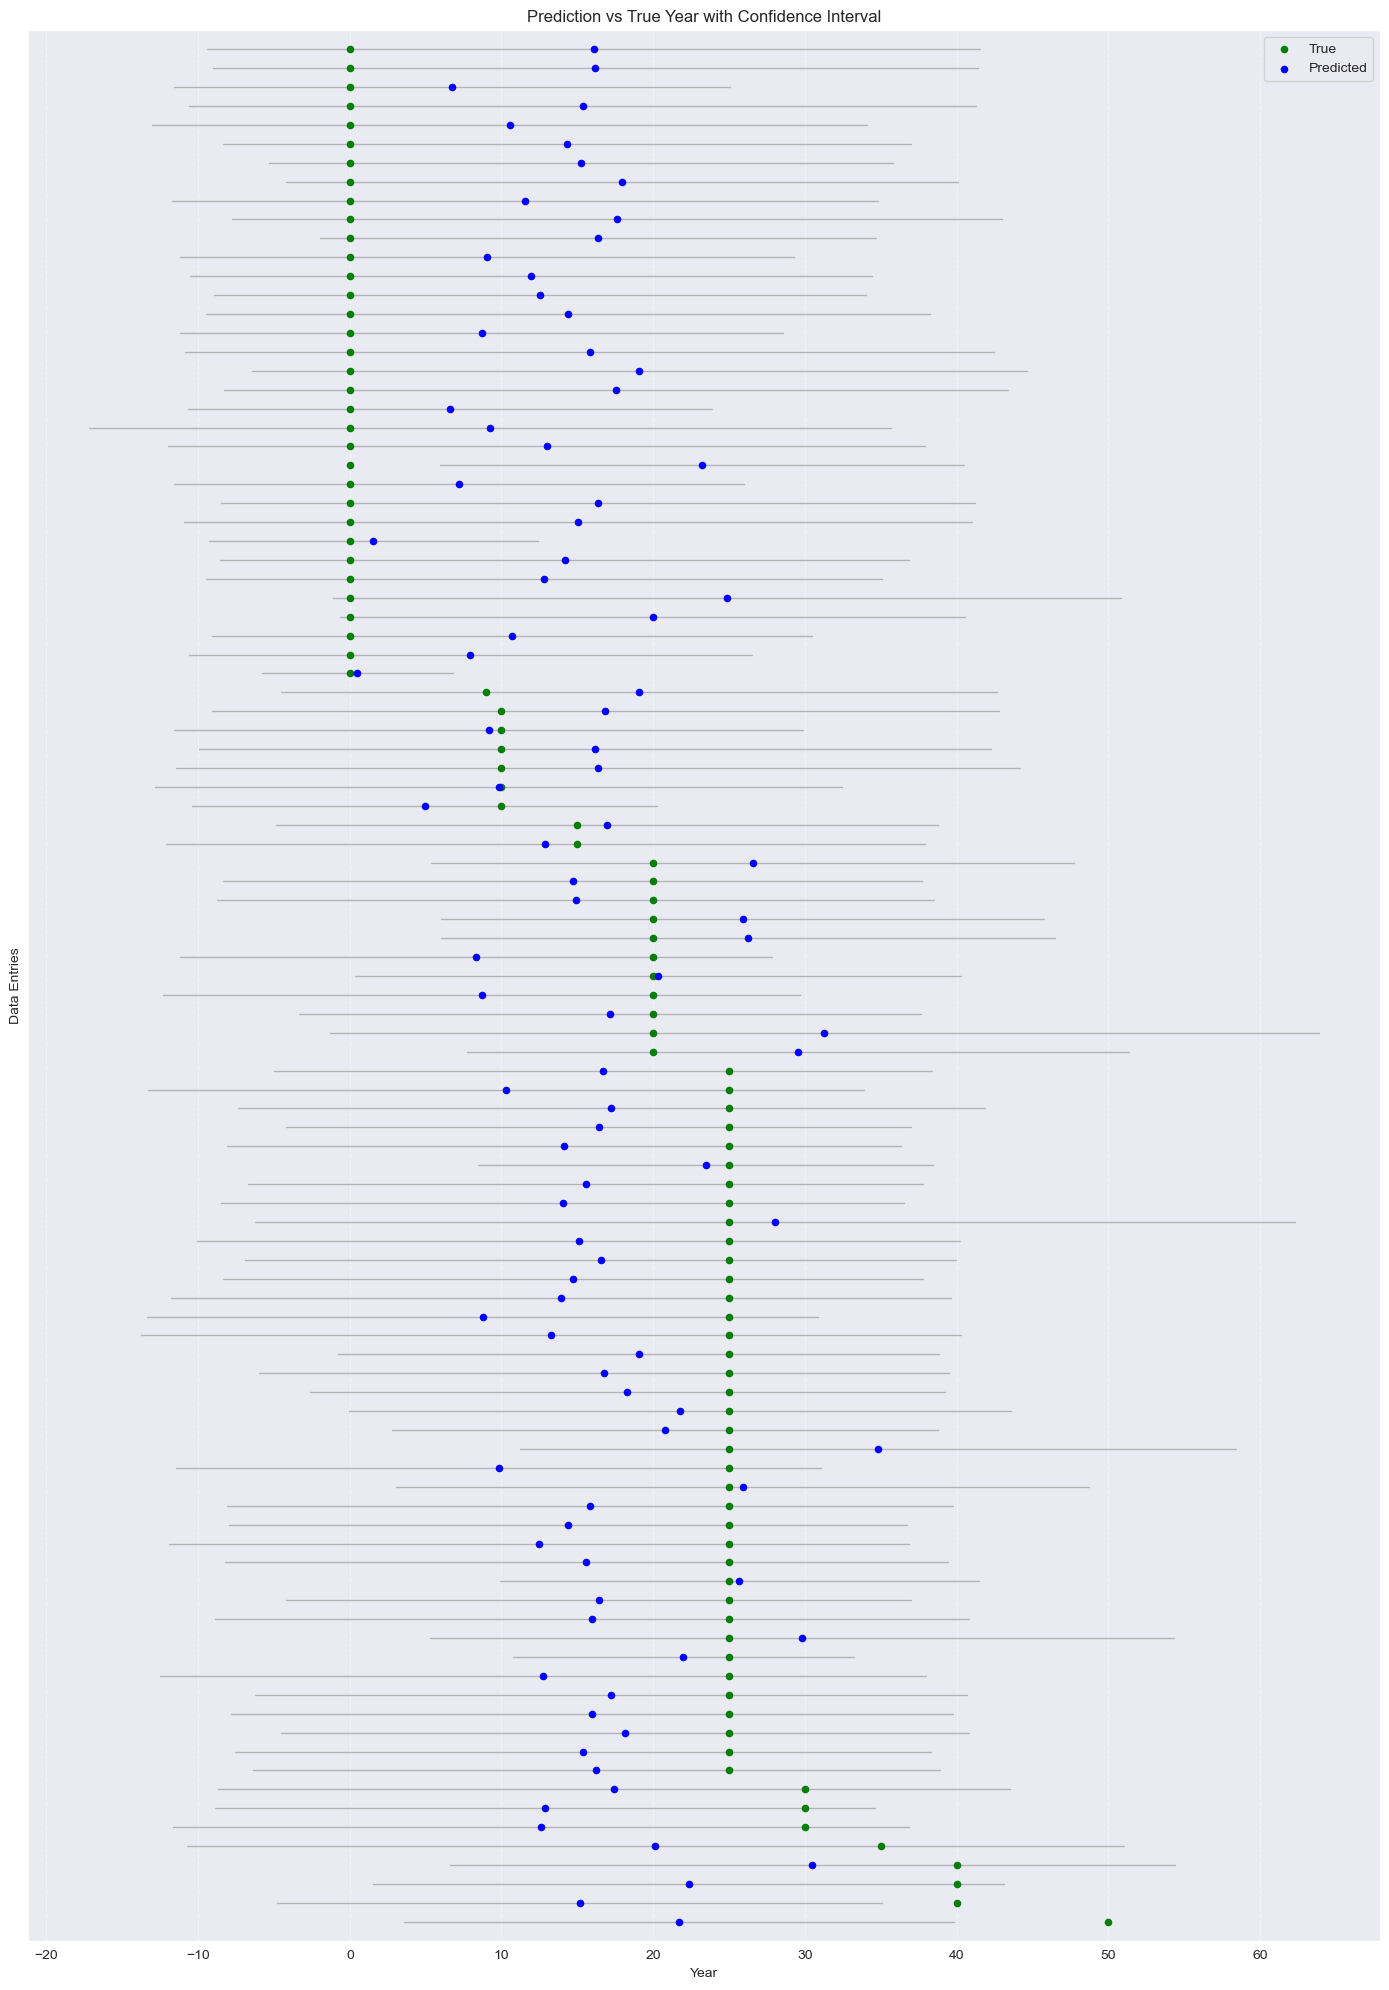

In [113]:
plot_true_vs_pred(results, 100)